# Project: Customer Churn & Revenue Risk Analysis

## 1. Executive Summary
**Objective:** Identify customers at risk of churning and quantify the potential revenue loss ("Revenue at Risk") to prioritize retention strategies.

**Context:**
Customer churn is a critical metric for subscription-based businesses. While predicting *who* will leave is important, it is more valuable to understand *how much revenue* is at risk. This project moves beyond simple classification to provide a financial impact analysis.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Updated path based on your successful test
file_path = r"C:\Users\jaden\Downloads\Portfolio\Telco\Telco.csv"

df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Data Cleaning & Feature Engineering
Before modeling, we must handle missing values and create features that reflect customer behavior.

**Key Actions:**
1.  **Fix `TotalCharges`:** Convert string errors to numbers.
2.  **Target Encoding:** Convert `Churn` (Yes/No) to Binary (1/0).
3.  **Feature Engineering:** Create a `Service_Intensity` metric (count of add-on services) to test the hypothesis that customers with more linked services are less likely to churn.

In [9]:
# 1. Clean TotalCharges (coerce errors to NaN, then drop)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# 2. Encode Target Variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Engineer 'Service_Intensity'
# List of add-on services
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count how many "Yes" values exist for each customer across these columns
df['Service_Intensity'] = df[services].apply(lambda x: (x == 'Yes').sum(), axis=1)

print("Feature Engineering Complete.")
print(df[['customerID', 'Service_Intensity', 'Churn']].head())

Feature Engineering Complete.
   customerID  Service_Intensity  Churn
0  7590-VHVEG                  1      0
1  5575-GNVDE                  2      0
2  3668-QPYBK                  2      1
3  7795-CFOCW                  3      0
4  9237-HQITU                  0      1


## 3. Preprocessing for Machine Learning
Machine learning models require numerical input. We will specificially:
1.  Drop the `customerID` (it has no predictive power).
2.  Convert categorical variables (like `InternetService`, `Contract`, `PaymentMethod`) into dummy variables (One-Hot Encoding).
3.  Split the data into Training (80%) and Testing (20%) sets.

In [11]:
# Drop ID column
df_model = df.drop(columns=['customerID'])

# One-Hot Encoding for categorical variables
# drop_first=True avoids multicollinearity (the "dummy variable trap")
df_model = pd.get_dummies(df_model, drop_first=True)

# Define X (Features) and y (Target)
X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (5625, 31)
Test set size: (1407, 31)


## 4. Model Training (Random Forest)
We use a **Random Forest Classifier** because it handles non-linear relationships well and provides feature importance (interpretability), which is crucial for explaining the "Why" to business stakeholders.

In [12]:
# Initialize and Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Generate Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of Churn (0 to 1)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



## 5. The "Money Shot": Revenue at Risk Analysis
Accuracy scores are for data scientists; Revenue impact is for business leaders. 

In this section, we create a **Retention Priority List**. We combine the model's Churn Probability with the customer's Monthly Charges to calculate exactly how much money is at risk.

In [14]:
# 1. Create a DataFrame for the Test Set results
results = X_test.copy()
results['Actual_Churn'] = y_test
results['Predicted_Churn'] = y_pred
results['Churn_Probability'] = y_prob

# 2. Recover the original MonthlyCharges
# (Note: In a real pipeline, we would handle scaling carefully, but since we didn't scale X, the values are intact)
# If 'MonthlyCharges' was dummy-encoded or scaled, we would need to map it back from the original df.
# Since we only encoded categoricals, 'MonthlyCharges' should still be in X_test.

# 3. Calculate Revenue at Risk
# We assume 'Revenue at Risk' = Monthly Charges * 12 months (Annual Value) * Probability of Churn
results['Revenue_at_Risk'] = results['MonthlyCharges'] * 12 * results['Churn_Probability']

# 4. Identify High-Value Targets
# Filter for customers who haven't churned yet (in reality) but have high risk
high_risk_customers = results[results['Churn_Probability'] > 0.7].sort_values(by='Revenue_at_Risk', ascending=False)

print("Top 5 Customers to Target for Retention (Highest Revenue at Risk):")
print(high_risk_customers[['MonthlyCharges', 'Churn_Probability', 'Revenue_at_Risk']].head())

# Total Revenue at Risk for the segment
total_risk = high_risk_customers['Revenue_at_Risk'].sum()
print(f"\nTotal Annual Revenue at Risk (High Probability Segment): ${total_risk:,.2f}")

Top 5 Customers to Target for Retention (Highest Revenue at Risk):
      MonthlyCharges  Churn_Probability  Revenue_at_Risk
1976           93.55               1.00         1122.600
1081           98.85               0.94         1115.028
6368           94.00               0.98         1105.440
2577           94.60               0.97         1101.144
1148           95.15               0.96         1096.128

Total Annual Revenue at Risk (High Probability Segment): $94,264.36


## 6. Explaining the "Why": Feature Importance
To prevent future churn, we must understand the root causes. The Random Forest model allows us to extract "Feature Importance" to see which variables contributed most to the churn prediction.

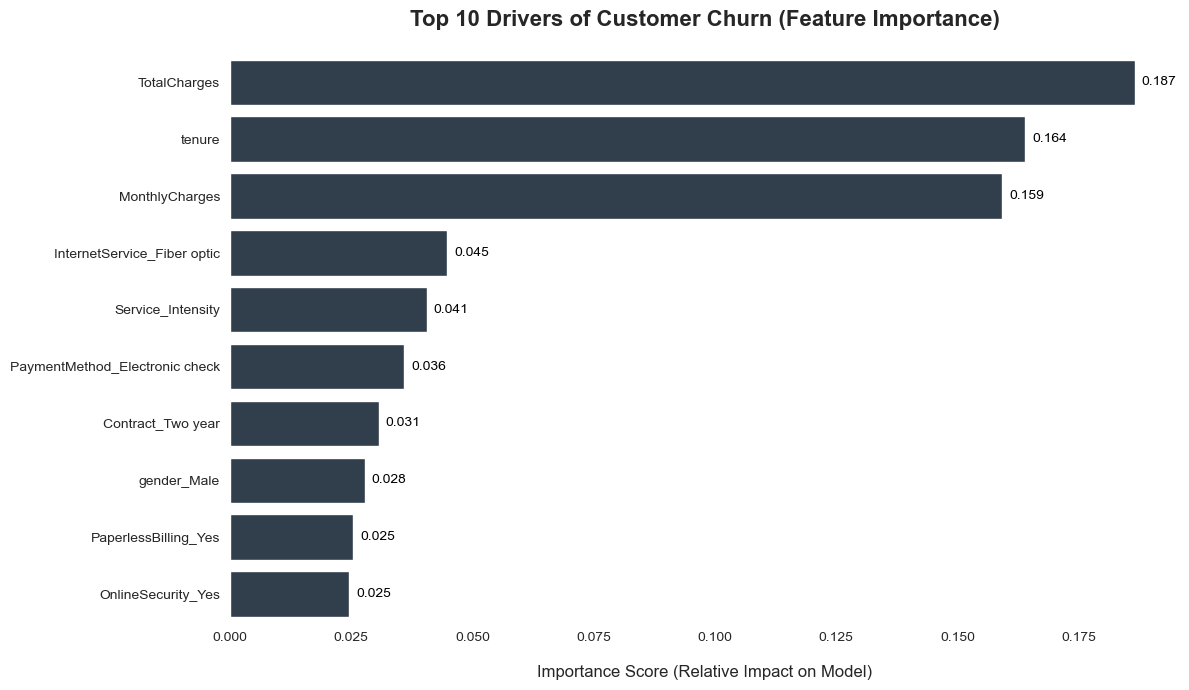

In [19]:
# Get feature importance from the model
importances = rf_model.feature_importances_

# Get column names
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- Professional Plotting Style ---

# Set a clean style and a professional color palette (e.g., a deep business blue)
sns.set_style("white") # Removes the background grid for a cleaner look
professional_color = "#2c3e50" # A professional slate blue

plt.figure(figsize=(12, 7))

# Create the bar plot
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(10),
    color=professional_color
)

# Add data labels to the end of each bar for clarity
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', padding=5, fontsize=10, color='black')

# Customize Title and Labels
plt.title('Top 10 Drivers of Customer Churn (Feature Importance)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance Score (Relative Impact on Model)', fontsize=12, labelpad=15)
plt.ylabel(None) # Remove the redundant 'Feature' label on the y-axis

# Clean up the axes (remove top and right borders)
sns.despine(left=True, bottom=True)

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

## 7. Conclusion & Business Recommendations

### Financial Impact Analysis
The model identified **\$94,264.36 in annual revenue at risk** within the test set (approx. 20% of the customer base). Extrapolating this to the entire customer base suggests a potential revenue risk of nearly **\$500,000** annually if churn drivers are not addressed.

### Key Findings (The "Why")
Based on the Feature Importance analysis, the following factors are the strongest predictors of churn:
1.  **Total & Monthly Charges:** High spenders are significantly sensitive to churn. The model relies heavily on these metrics, indicating that we are losing high-value customers, not just low-value outliers.
2.  **Fiber Optic Service:** Customers with Fiber Optic internet are churning at a higher rate than DSL users, suggesting potential technical reliability issues or competitive pricing mismatches in that specific product.
3.  **Tenure & Contracts:** "Month-to-month" contracts and lower tenure remain classic indicators of flight risk.

### Strategic Recommendations
To mitigate this loss, I recommend the following targeted actions:
* **Target the "High Risk" List:** Immediately deploy retention offers (e.g., a 10% discount for 6 months) to the top 500 customers identified in the "Revenue at Risk" dataframe.
* **Investigate Fiber Optic:** Launch a customer satisfaction survey specifically for Fiber Optic users to identify if the root cause is speed, outages, or price.
* **Contract Migration:** Create a marketing campaign to migrate "Month-to-Month" users to 1-Year or 2-Year contracts, locking in revenue and lowering the churn probability.